In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Load local modules
import sys
sys.path.append('d:\\Users\\serfe\\Documents\\GitHub\\seisinv\\src')
from basic_ops_seis_inv import Filtering, ConversionTool, MathOps, Error
from tqdm import tqdm

c:\Users\serfe\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


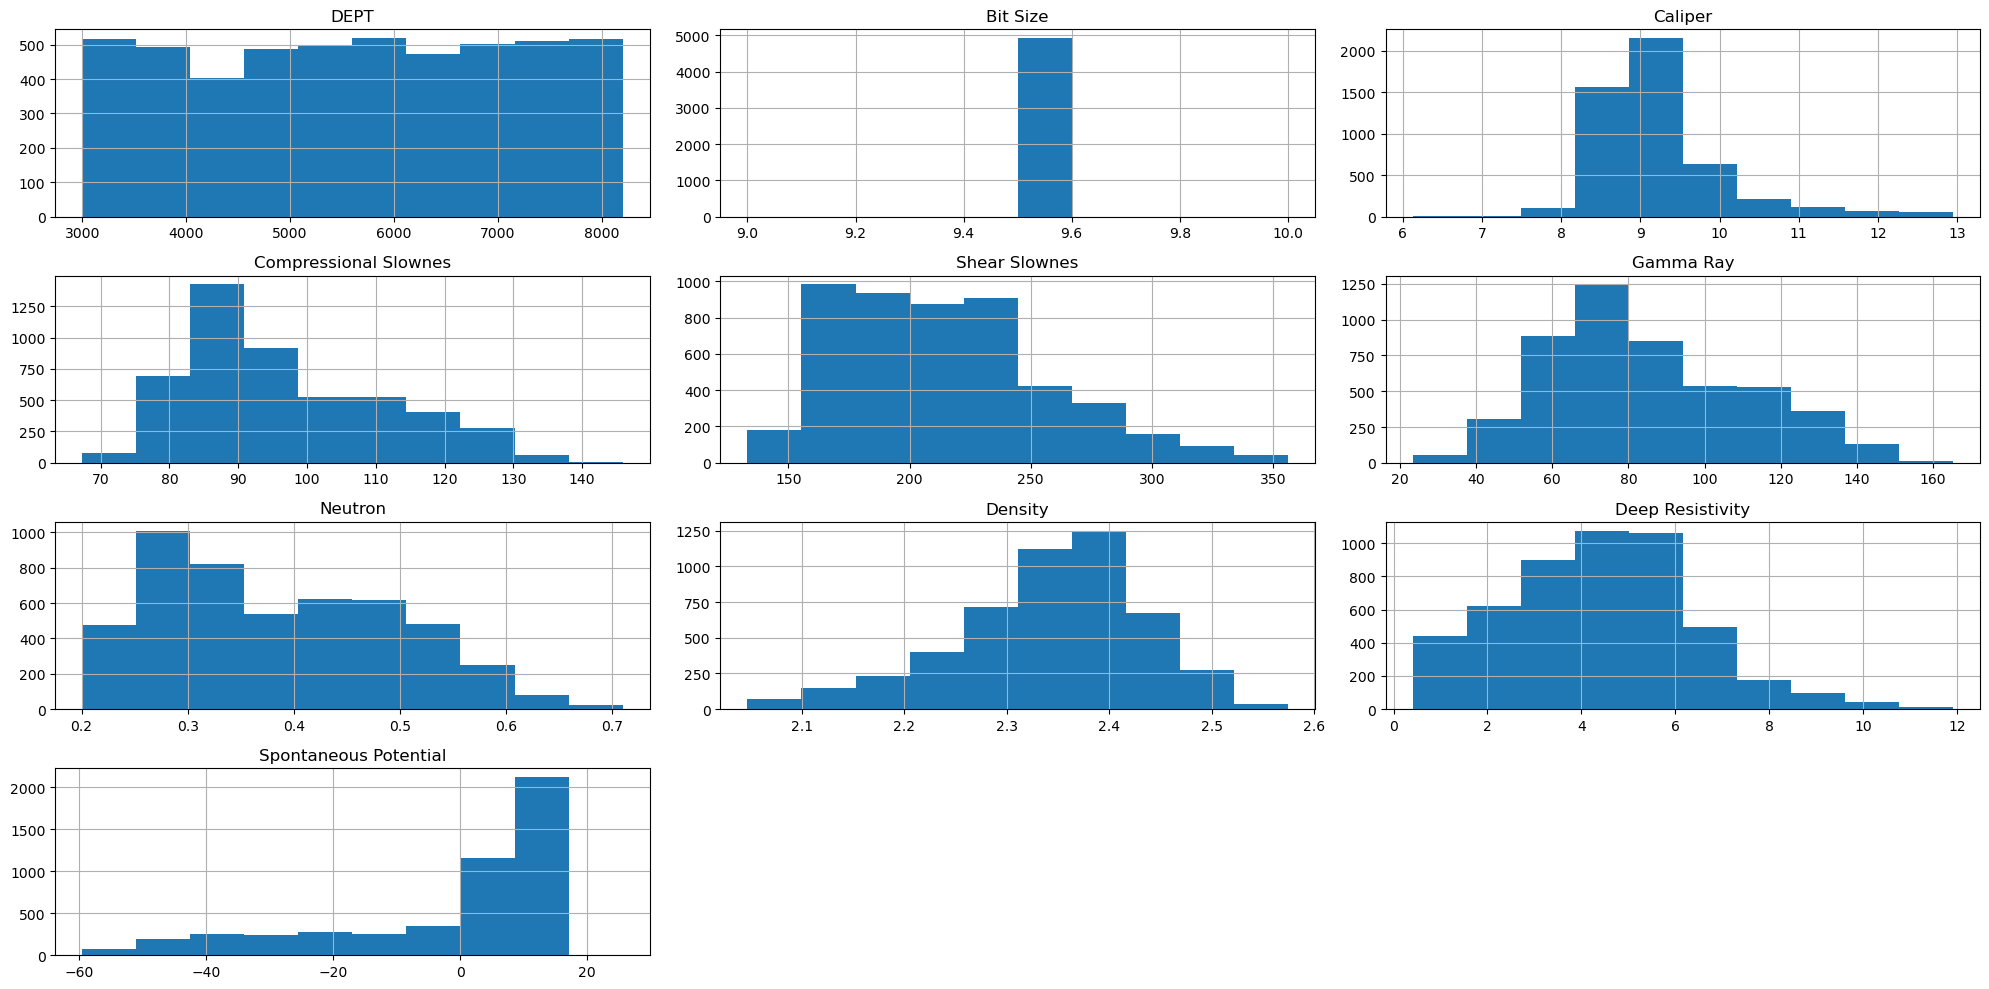

In [2]:
# Load data
path_data = 'd:\\Users\\serfe\\Documents\\GitHub\\seisinv\\data\\Task2_data.xlsx'
df = pd.read_excel(path_data)
# Remove outliers
df = Filtering().remove_outliers(df, drop_col=['Surface', 'Bit Size'])
# Plot data
df.hist(figsize=(20,10))
plt.tight_layout()

In [3]:
# Backus conversion to seismic domain
vp = 1 / ConversionTool().SI_conversion(df['Compressional Slownes'], 'micros/ft')
vs = 1 / ConversionTool().SI_conversion(df['Shear Slownes'], 'micros/ft')
rho = ConversionTool().SI_conversion(df['Density'], 'g/cm3')
depth = df['DEPT']
vp0, vs0, rho0, dept0 = ConversionTool(104, vp, vs, rho, 3000, depth).backus_downsampling()

Output units: kg/m3
Original sampling frequency (in well-log domain) is: 14853.21312132847 Hz
New sampling frequency (in seismic domain) is: 119.49768920340398 Hz


Text(0.5, 1.0, 'Backus conversion: From Well-log domain to Seismic domain')

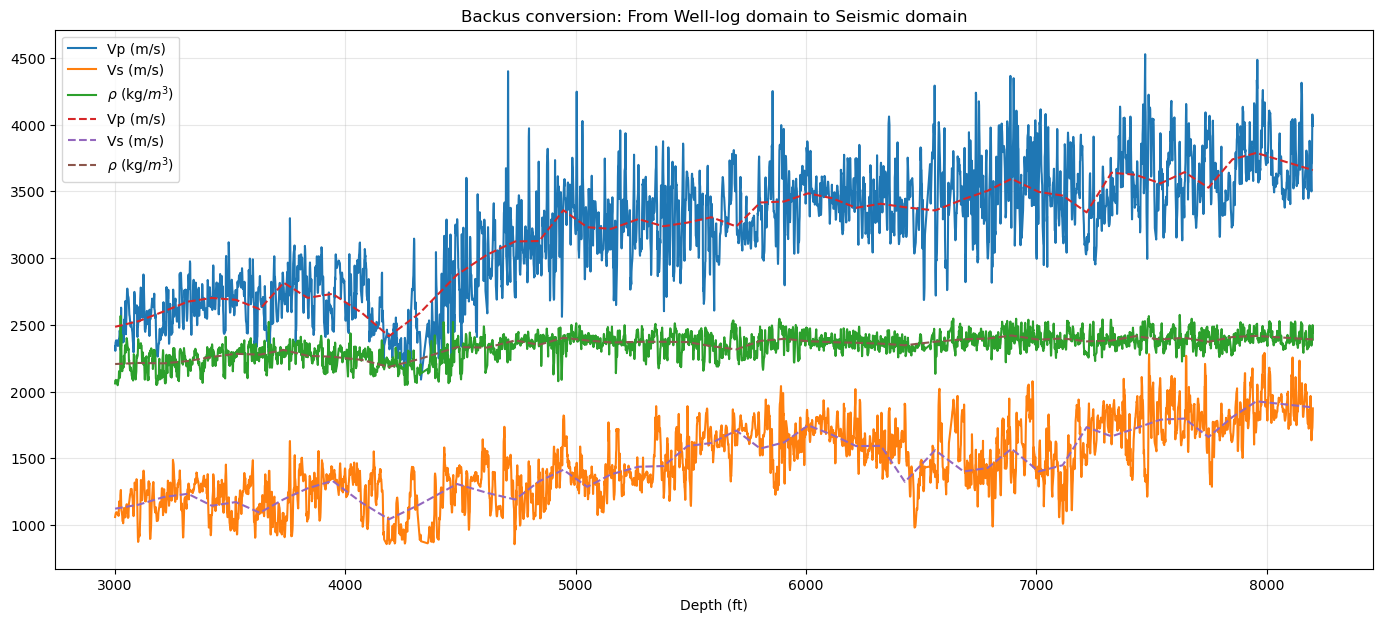

In [4]:
# Plot resmapled data
fig = plt.figure(figsize=(17,7))
plt.plot(df.DEPT, vp, label='Vp (m/s)')
plt.plot(df.DEPT, vs, label='Vs (m/s)')
plt.plot(df.DEPT, rho, label=fr'$\rho$ (kg/$m^3$)')
plt.plot(dept0, vp0, label='Vp (m/s)', linestyle='dashed')
plt.plot(dept0, vs0, label='Vs (m/s)', linestyle='dashed')
plt.plot(dept0, rho0, label=fr'$\rho$ (kg/$m^3$)', linestyle='dashed')
plt.xlabel('Depth (ft)')
plt.grid(alpha=.3)
plt.legend(ncol=1)
plt.title('Backus conversion: From Well-log domain to Seismic domain')

# Seismic Genetic Inversion

Text(0, 0.5, 'Depth (ft)')

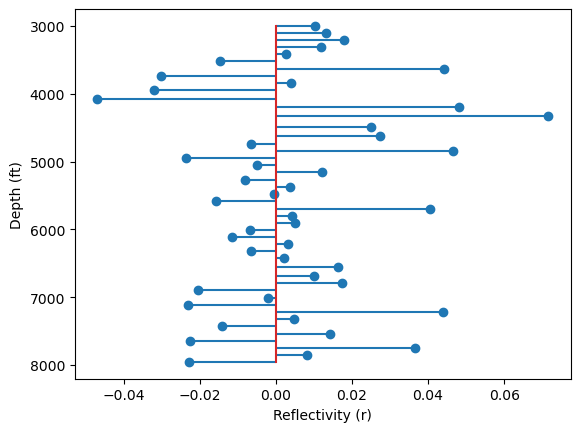

In [5]:
# Calculate the original reflectivity profile (obtained from well-log to seismic domain)
math_ops = MathOps(vp=vp0, rho=rho0)
Z = math_ops.calc_impedance()
r = math_ops.calc_r(Z_data=Z)
plt.stem(dept0[:-1], r, orientation='horizontal')
plt.gca().invert_yaxis()
plt.xlabel('Reflectivity (r)')
plt.ylabel('Depth (ft)')

In [6]:
print(f'There are {len(vp0)} samples in the new seismic domain.')

There are 47 samples in the new seismic domain.


We will create 10000 random models with some constrains for $v_p$, $v_s$ and $\rho$. As there are 47 samples, we will create 47 gens, that will form a chromosome. The folllowing is na example of 1 chromosome formed by 47 gens.

In [7]:
M_shape = (47, 10000000)
# Initialize the random values for Vp, Vs a,d rho that are going to form the chromosome.
rho_gen = np.random.uniform(2.1, 2.8, M_shape)*1000
vs_gen = np.random.uniform(1.0, 2.0, M_shape)*1000
vp_gen = np.random.uniform(2.4, 3.8, M_shape)*1000

In [8]:
# One chromosome from 10000 possible chromosomes
# Each cell/row is a gen
def one_chromosome(n_chromosome=0, print_=False):
    rho_chromosome = rho_gen[:,n_chromosome]
    vp_chromosome = vp_gen[:,n_chromosome]
    vs_chromosome = vs_gen[:,n_chromosome]
    chromosome = np.stack([rho_chromosome, vp_chromosome, vs_chromosome], axis=1)
    # Now let's calculate the reflectivity profile for the chromosome
    math_ops = MathOps(vp=vp_chromosome, rho=rho_chromosome)
    Z_chromosome = math_ops.calc_impedance()
    r_chromosome = math_ops.calc_r(Z_data=Z_chromosome)
    # Now compare the real reflectivity profile with the generic one.
    error = Error(y_true=r, y_pred=r_chromosome)
    l1_error, l2_error = error.l1_error(), error.l2_error()

    if print_:
        print(fr'The columns are: $\rho$, $v_p$, $v_s$')
        print('Example of 1 chromoosme with 47 gens', '\n')
        print(chromosome)
        print('Errors between original and chromosome reflectivity profiles.', '\n')
        print(f'l1 error: {l1_error}%')
        print(f'l2 error: {l2_error}%')
    
    if l1_error <= 5:
        return l1_error, l2_error, chromosome
    else:
        return 9999, 9999, 9999

In [9]:
l1_error, l2_error, chromosome = one_chromosome( n_chromosome=0, print_=True)

The columns are: $\rho$, $v_p$, $v_s$
Example of 1 chromoosme with 47 gens 

[[2712.0379972  3315.20020228 1808.99973388]
 [2685.69184076 3662.77457934 1264.68388243]
 [2762.49921326 3084.1855334  1452.28967467]
 [2250.22307541 3269.98279153 1590.8094536 ]
 [2278.78018883 3276.09128516 1593.80071028]
 [2508.83480071 3212.70456051 1375.58259511]
 [2557.28323255 2715.52852444 1427.56246009]
 [2798.06255617 3356.14948722 1114.86042128]
 [2708.98434758 2437.65630473 1390.79033162]
 [2690.74096609 3280.06293188 1580.50656592]
 [2750.79245897 2652.33131389 1990.37472125]
 [2232.10829737 3068.3441332  1429.13478553]
 [2595.0499357  3375.30443059 1005.33824304]
 [2377.41825647 2554.1652045  1947.59104356]
 [2188.61694671 3190.34497876 1267.33638699]
 [2141.42966912 3282.32709676 1014.8978975 ]
 [2348.3146343  3044.76849897 1246.69051201]
 [2711.7188663  2729.79922505 1474.56681415]
 [2403.56462632 3147.54292471 1272.13350045]
 [2614.76253841 3677.75871423 1122.31996577]
 [2681.68412252 3609.98

We have seen an example in which we built a chromosome, then calculated its reflectivity profile and finally compared results with the original one to evaluate what the similarity/error between the two reflectivity profiles is. Now, let's apply the same steps to multiple chromosomes and keep only those whose error is smaller than 5%.

In [10]:
df = pd.DataFrame(columns=['l1_error', 'l2_error', 'chromosome'])
for i in tqdm(range(rho_gen.shape[1])): # for 100000 chromosomes
    l1_error, l2_error, chromosome = one_chromosome(n_chromosome=i, print_=False)
    if l1_error != 9999:
        df = df.append({'l1_error':l1_error, 'l2_error':l2_error, 'chromosome': chromosome}, ignore_index=True)
print(f'{len(df)} from {rho_gen.shape[1]} chromosomes survivied.')


100%|██████████| 10000000/10000000 [08:26<00:00, 19742.75it/s]

116 from 10000000 chromosomes survivied.


We save chromosomes with l1 error less than 5%.

In [94]:
print(f'We got {len(df)} candidate chromosomes.')
print(f'The lowest l1 error among the candidates is: {df.l1_error.min()}%')
df

We got 116 candidate chromosomes.
The lowest l1 error among the candidates is: 4.288426489591%


,l1_error,l2_error,chromosome
0,4.788223,0.895570,"[[2405.8878412637278, 2838.7059203637723, 1155..."
1,4.670367,0.966682,"[[2261.895553599189, 2637.4738953960464, 1098...."
2,4.565027,0.916465,"[[2167.487751514218, 3530.976929446289, 1134.8..."
3,4.731320,0.897552,"[[2385.1239271282325, 3619.9806470928193, 1291..."
4,4.790778,0.908943,"[[2520.5643786134287, 2747.921626428624, 1839...."
...,...,...,...
111,4.985207,0.953288,"[[2463.339825846787, 3021.5320598748335, 1358...."
112,4.986513,0.915402,"[[2787.2760658676284, 2515.1640876205547, 1744..."
113,4.799385,1.014237,"[[2664.1361816292033, 3158.40820923907, 1724.0..."
114,4.721580,0.986805,"[[2597.4611121518865, 2601.945702093549, 1726...."


Now let's mix the survivor chromosomes using the genetic operators (mutation and crossover)

In [22]:
# Mutation operator
def mutation(chromosome, mutation_rate):
    # Implement a mutation operation here
    # For example, you can randomly perturb the chromosome's parameters
    # with a probability given by the mutation_rate
    mutated_chromosome = chromosome.copy()  # Make a copy of the chromosome
    min_rho, max_rho = chromosome[:,0].min(), chromosome[:,0].max()
    min_vp, max_vp = chromosome[:,1].min(), chromosome[:,1].max()
    min_vs, max_vs = chromosome[:,2].min(), chromosome[:,2].max()
    for i in range(len(chromosome)):
        if np.random.random() < mutation_rate:
            # Mutate each parameter (vp, vs, rho) independently
            mutated_chromosome[i, 0] = np.random.uniform(min_rho, max_rho)
            mutated_chromosome[i, 1] = np.random.uniform(min_vp, max_vp)
            mutated_chromosome[i, 2] = np.random.uniform(min_vs, max_vs)
    return mutated_chromosome

In [122]:
# Crossover operator
def crossover(parent1, parent2):
    # Implement a crossover operation here to combine two parent chromosomes
    # For example, you can choose a random crossover point and create a new chromosome
    crossover_point = np.random.randint(1, len(parent1))  # Choose a random crossover point
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

In [72]:
def evaluate_fitness(initial_chromosomes, observed_profile):
    fitness_values = []
    for model in initial_chromosomes:
        math_ops = MathOps(vp=model[:,0], rho=model[:,1])
        Z_chromosome = math_ops.calc_impedance()
        r_chromosome = math_ops.calc_r(Z_data=Z_chromosome)
        error = Error(y_true=observed_profile, y_pred=r_chromosome)
        l1_error = error.l1_error()
        fitness_values.append(l1_error)
    return np.array(fitness_values).min(), np.array(fitness_values).argmin()

In [143]:
# Assuming you have an initial list with 115 chromosomes, each with 47x3 shape
initial_chromosomes = df['chromosome'].values  # List of initial chromosomes

# Set genetic algorithm parameters
mutation_rate = 0.1  # Adjust the mutation rate as needed
population_size = 10000  # Set the population size
max_generations = 500  # Set the maximum number of generations

# Initialize the best model and best fitness
best_model = None
best_fitness = float('inf')

# Main genetic algorithm loop
for generation in range(max_generations):
    new_population = []
    
    # Elitism: Keep the best-performing chromosomes from the previous generation
    new_population.extend(initial_chromosomes)
    
    while len(new_population) < population_size:
        # Select parent chromosomes (e.g., using tournament selection)
        parent1 = np.random.choice(initial_chromosomes)
        parent2 = np.random.choice(initial_chromosomes)
        
        # Apply crossover to create a new chromosome
        child = crossover(parent1, parent2)
        
        # Apply mutation to the child with a certain probability
        child = mutation(child, mutation_rate)
        
        # Add the child to the new population
        new_population.append(child)
    
    # Replace the old population with the new population
    initial_chromosomes = new_population

    # Evaluate fitness and select the best models
    # (Use your L1 error function to evaluate fitness)
    
    current_fitness, idx_current_fitness = evaluate_fitness(initial_chromosomes, r)

    # Check if the current generation produced a better model
    if current_fitness < best_fitness:
        best_fitness = current_fitness
        best_model = initial_chromosomes[idx_current_fitness]  # You can choose the best model in various ways
        
# The best_model now contains the best model found by the genetic algorithm

In this point we have already found the best model by using genetic algorithms. Now, let's evalaute how well does out best model by comparing the predicted rho, vp, and vs with the original ones.

In [144]:
# Calculate r for the best model.
math_ops = MathOps(vp=best_model[:,0], rho=best_model[:,1])
Z_chromosome = math_ops.calc_impedance()
r_chromosome = math_ops.calc_r(Z_data=Z_chromosome)
# Calculate error between r's of original observed profile and calculated profile
error = Error(y_true=r, y_pred=r_chromosome)
l1_error = error.l1_error()
print('Error between predicted model and real model', '\n')
print(f'l1 error: {l1_error}')

Error between predicted model and real model 

l1 error: 3.065985509323725


Text(0.5, 1.0, 'Comparison of Seisimc Genetic Inversion')

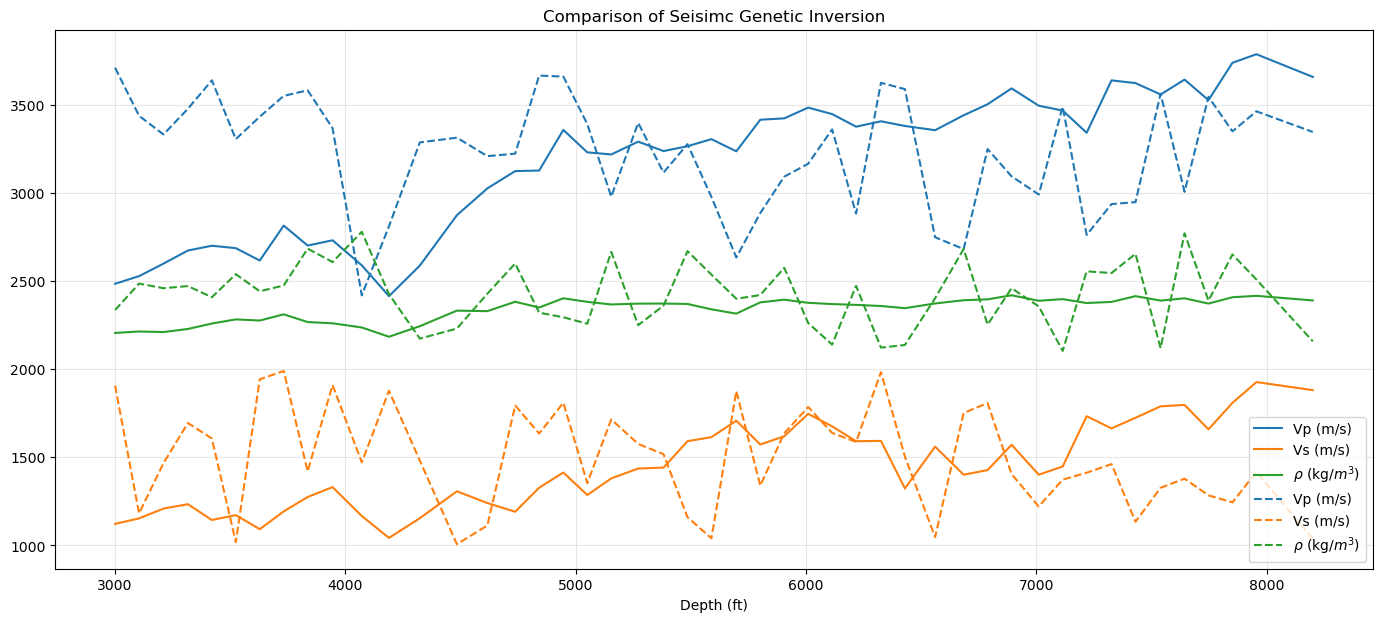

In [145]:
# Plot resmapled data
fig = plt.figure(figsize=(17,7))
plt.plot(dept0, vp0, label='Vp (m/s)', color='C0')
plt.plot(dept0, vs0, label='Vs (m/s)', color='C1')
plt.plot(dept0, rho0, label=fr'$\rho$ (kg/$m^3$)', color='C2')
plt.plot(dept0, best_model[:,1], label='Vp (m/s)', linestyle='dashed', color='C0')
plt.plot(dept0, best_model[:,2], label='Vs (m/s)', linestyle='dashed', color='C1')
plt.plot(dept0, best_model[:,0], label=fr'$\rho$ (kg/$m^3$)', linestyle='dashed', color='C2')
plt.xlabel('Depth (ft)')
plt.grid(alpha=.3)
plt.legend(ncol=1)
plt.title('Comparison of Seisimc Genetic Inversion')

Continuous lines are for observed values and dashed lines are for seismic inversion obtained through genetic algorithms. The L1 error between reflectivity profiles is small 5%, but the inversion gives us a very different model for vp, vs and rho, showing a problem of non-uniqueness.